# PCA autoencoder
Author: **[Carl McBride Ellis](https://u-tad.com/claustro/carl-mcbride-ellis/)**

In [1]:
import numpy as np
np.random.seed(42)
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

import sklearn
#sklearn.set_config(transform_output="pandas")

Create our synthetic dataset

In [2]:
b1 =  3
b0 = 15

X = np.arange(-5, 5, 0.05)
y = b1*X + b0
jitter = 4*(np.random.normal(loc=0.0, scale=1.0, size=len(X))-0.5)
y = y+jitter
dataset = np.column_stack([X,y])

In [3]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(dataset)
dataset = scaler.transform(dataset)

Take a look at our data

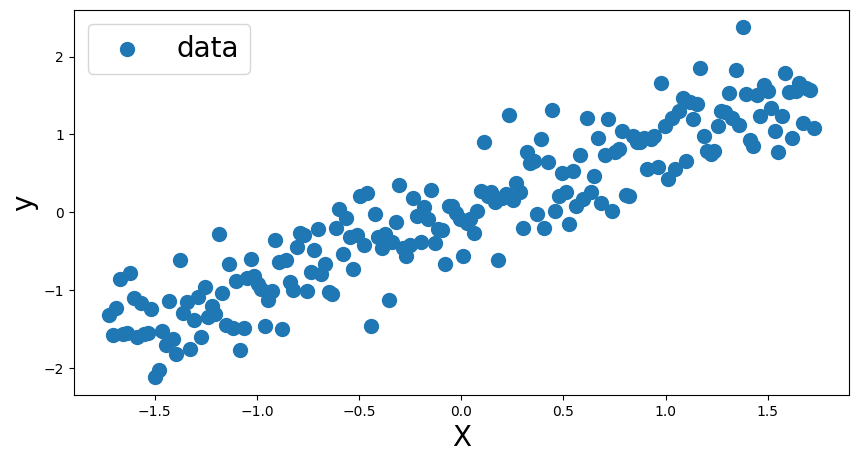

In [4]:
fig = plt.figure(figsize=(10, 5))
plt.scatter(dataset[:,0], dataset[:,1], s=100, label='data')
plt.legend(loc='upper left', fontsize=20)
plt.xlabel('X', fontsize=20)
plt.ylabel('y', fontsize=20);

## Feature correlation

In [5]:
pd.DataFrame(dataset).corr().style.background_gradient(cmap='coolwarm', axis=None)

,0,1
0,1.000000,0.923568
1,0.923568,1.000000


# Part I: Using Scikit-learn

In [6]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(dataset)

# print(pca.explained_variance_)
# print(pca.explained_variance_ratio_)
# print(pca.singular_values_)

transformed = pca.transform(dataset)

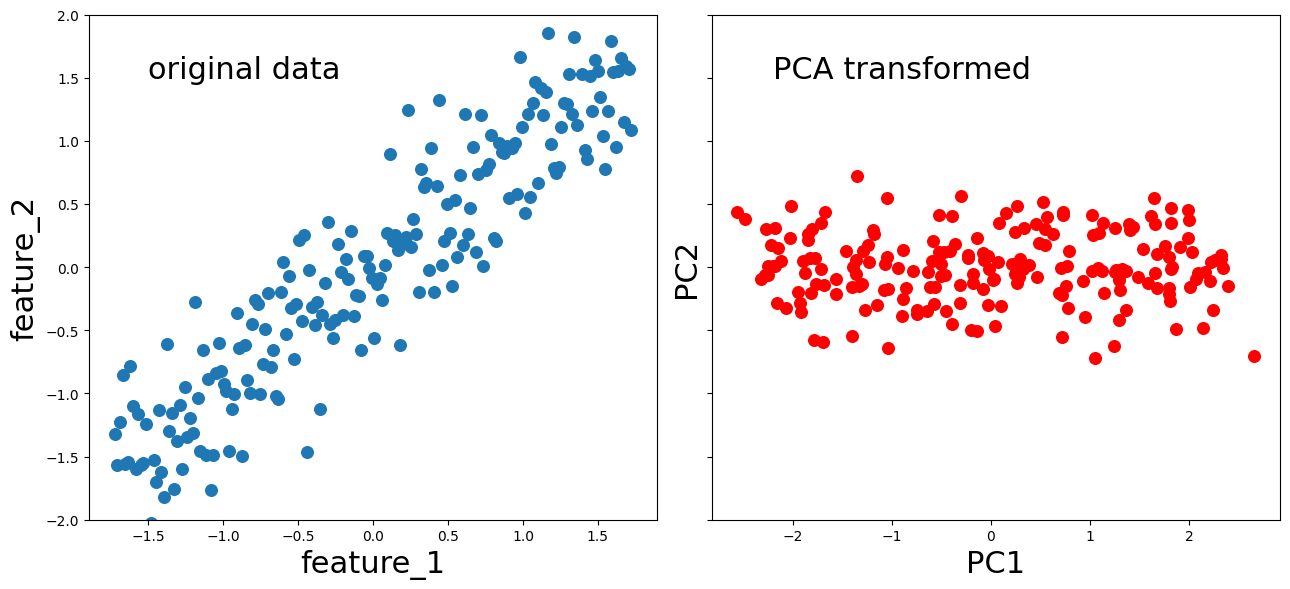

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 6), sharey=True)

axes[0].scatter(dataset[:,0], dataset[:,1], s=70,  label='original data')
axes[0].set_ylim([-2,2])
axes[1].scatter(transformed[:,0], transformed[:,1], s=70, color="red", label='PCA transformed')
axes[0].set_xlabel('feature_1', fontsize=22)
axes[1].set_xlabel('PC1', fontsize=22)
axes[0].set_ylabel('feature_2', fontsize=22)
axes[1].set_ylabel('PC2', fontsize=22)

axes[0].text(-1.5,1.5, r"original data", fontsize=22)
axes[1].text(-2.2,1.5, r"PCA transformed", fontsize=22)

fig.tight_layout()

## Feature correlation
The principal components (PC1 and PC2) should no be completely uncorrelated

In [8]:
pd.DataFrame(transformed).corr().style.background_gradient(cmap='coolwarm', axis=None)

,0,1
0,1.000000,0.000000
1,0.000000,1.000000


# Part II: Using linear algebra

In [9]:
CM = np.cov(dataset, rowvar=False)

# Calculate the eigenvalues and eigenvectors
eigenvalues_CM, eigenvectors_CM = np.linalg.eig(CM)

idx = eigenvalues_CM.argsort()[::-1]  # sort
eigenvalues_CM = eigenvalues_CM[idx]
eigenvectors_CM = eigenvectors_CM[:,idx]

# Print the eigenvalues and eigenvectors
print('Eigenvalues: \n', eigenvalues_CM)
print('Eigenvectors: \n', eigenvectors_CM)

Eigenvalues: 
 [1.93323414 0.07681611]
Eigenvectors: 
 [[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]


In [10]:
# rotate the dataset
rotated = np.dot(dataset, eigenvectors_CM)

take a look

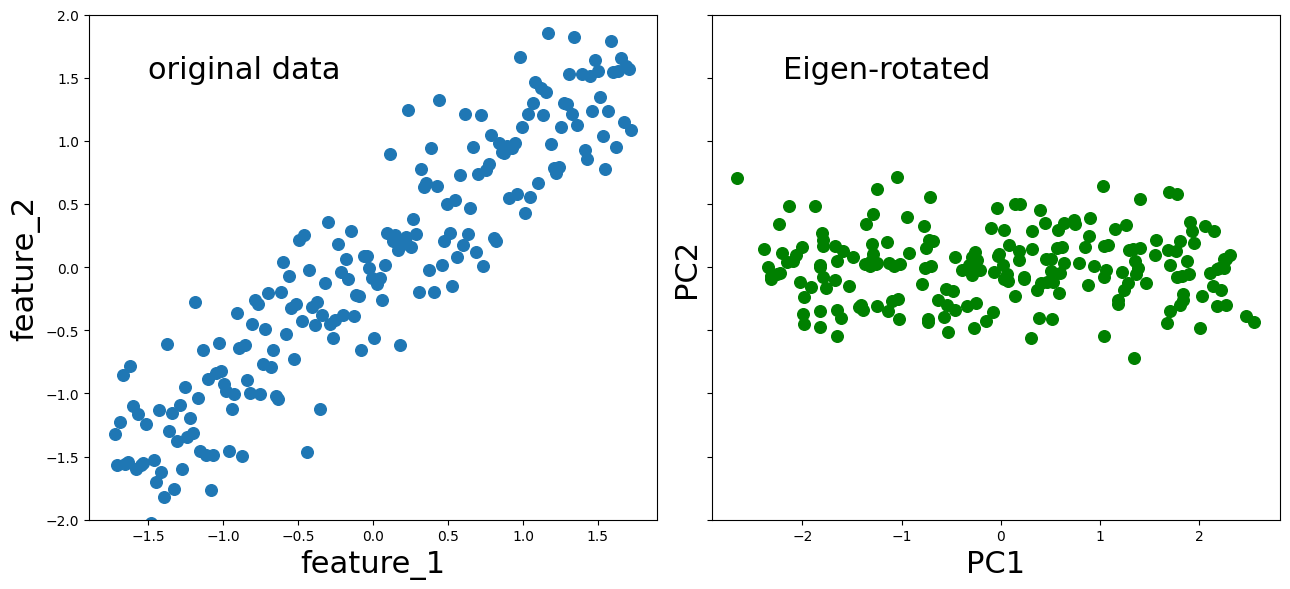

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 6), sharey=True)

axes[0].scatter(dataset[:,0], dataset[:,1], s=70,  label='original data')
axes[0].set_ylim([-2,2])
axes[1].scatter(rotated[:,0], rotated[:,1], s=70, color="green", label='Eigen transformed')
axes[0].set_xlabel('feature_1', fontsize=22)
axes[1].set_xlabel('PC1', fontsize=22)
axes[0].set_ylabel('feature_2', fontsize=22)
axes[1].set_ylabel('PC2', fontsize=22)

axes[0].text(-1.5,1.5, r"original data", fontsize=22)
axes[1].text(-2.2,1.5, r"Eigen-rotated", fontsize=22)

fig.tight_layout()

In [12]:
pd.DataFrame(rotated).corr().style.background_gradient(cmap='coolwarm', axis=None)

,0,1
0,1.000000,0.000000
1,0.000000,1.000000


# Part III: Using a neural-network autoencoder

In [13]:
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense

#keras.utils.set_random_seed(42)

In [14]:
input_dim = dataset.shape[1]
print("Input shape",input_dim)
encoding_dim = dataset.shape[1]

input_data = keras.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation=None)(input_data) # encoder / latent representation
decoded = layers.Dense(input_dim, activation=None)(encoded) # decoder

autoencoder = keras.Model(input_data, decoded)

Input shape 2


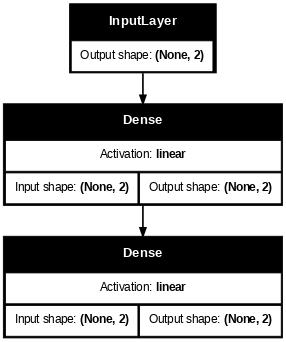

In [15]:
keras.utils.plot_model(autoencoder,
           show_shapes=True,
           show_layer_activations=True,
           dpi=60,)

In [16]:
callback = keras.callbacks.EarlyStopping(monitor="loss",
                                         min_delta=1.0e-10,)

autoencoder.compile(loss= 'mean_squared_error',
                    #optimizer= keras.optimizers.SGD(learning_rate=0.01),
                    optimizer = 'adam'
                    )

history = autoencoder.fit(dataset, # the input is the training data
                          dataset, # the target is the training data
                          epochs= 2500,
                          #callbacks=[callback],
                          verbose=0)

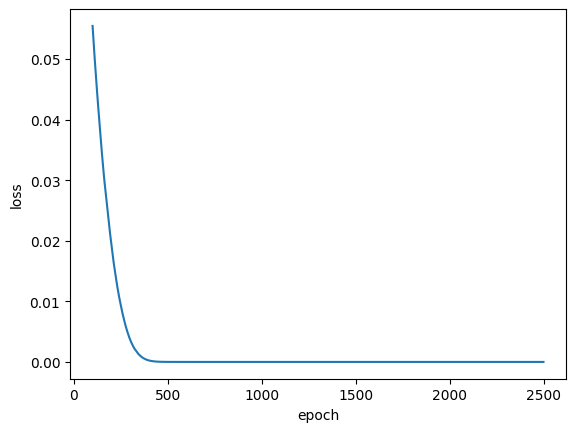

In [17]:
logs = pd.DataFrame(history.history)
plt.plot(logs.loc[100:,"loss"])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [18]:
# final MSE, the "reconstruction error"
logs.tail(1)

,loss
2499,1.260362e-08


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


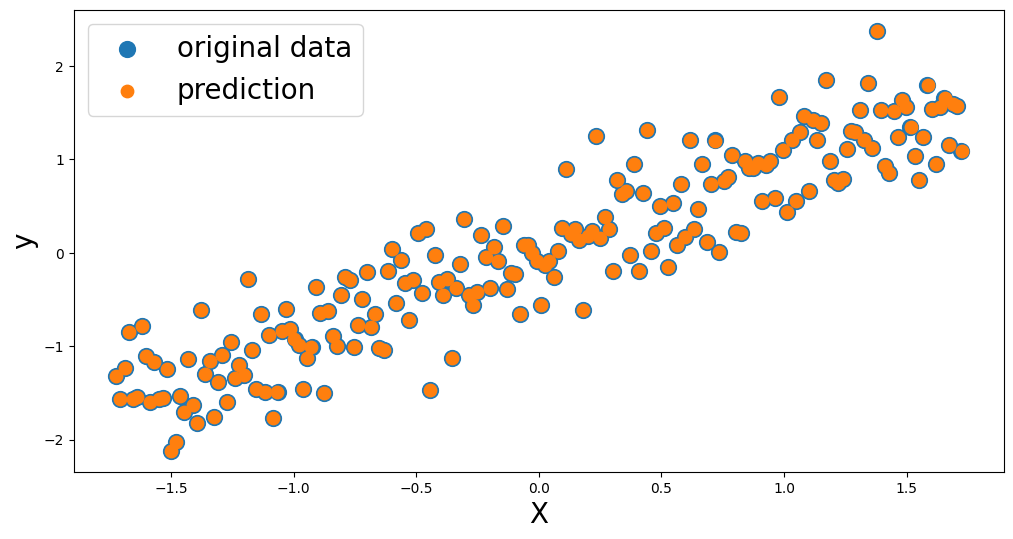

In [19]:
encoded_data = autoencoder.predict(dataset)

fig = plt.figure(figsize=(12, 6))
plt.scatter(dataset[:,0], dataset[:,1], s=130, label='original data')
plt.scatter(encoded_data[:,0], encoded_data[:,1], s=80, label='prediction')
plt.legend(loc='upper left', fontsize=20)
#plt.xlim(3,15)
plt.xlabel('X', fontsize=20)
plt.ylabel('y', fontsize=20);

## The PCA is in the latent representation of our now trained autoencoder

In [20]:
input_data = keras.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation=None)(input_data) # encoder / latent representation
latent_layer = keras.Model(input_data, encoded)

NN_PCA_data = latent_layer.predict(dataset)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


take a look

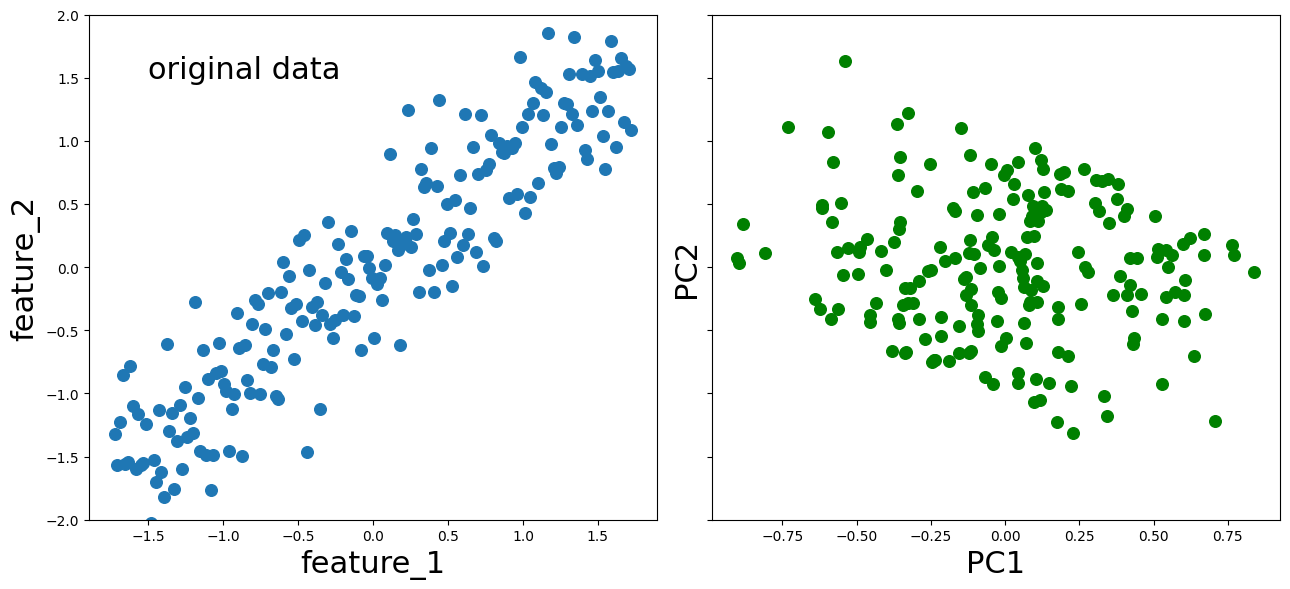

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 6), sharey=True)

axes[0].scatter(dataset[:,0], dataset[:,1], s=70,  label='original data')
axes[0].set_ylim([-2,2])
axes[1].scatter(NN_PCA_data[:,0], NN_PCA_data[:,1], s=70, color="green", label='autoencoder transformed')
axes[0].set_xlabel('feature_1', fontsize=22)
axes[1].set_xlabel('PC1', fontsize=22)
axes[0].set_ylabel('feature_2', fontsize=22)
axes[1].set_ylabel('PC2', fontsize=22)

axes[0].text(-1.5,1.5, r"original data", fontsize=22)
#axes[1].text(-2.2,1.5, r"autoencoder", fontsize=22)

fig.tight_layout()

In [22]:
pd.DataFrame(NN_PCA_data).corr().style.background_gradient(cmap='coolwarm', axis=None)

,0,1
0,1.000000,-0.121931
1,-0.121931,1.000000


Hmmm, not so good...

## Are the encoder and decoder weights "tied" (equal)

In [23]:
# Transpose of the encoder weights
e_weights, e_biases = autoencoder.layers[1].get_weights()
print(e_weights.T)
#print(biases)

[[-1.3790547  -0.6629782 ]
 [ 0.22781728  1.3448486 ]]


In [24]:
# Decoder weights
d_weights, d_biases = autoencoder.layers[2].get_weights()
print(d_weights)
#print(biases)

[[-0.78948075  0.1337793 ]
 [-0.38918227  0.8095148 ]]


In [25]:
# the weights are not orthogonal
np.round(np.dot(e_weights.T, d_weights), 2)

array([[ 1.35, -0.72],
       [-0.7 ,  1.12]], dtype=float32)

In [26]:
print(np.round(np.sum(e_weights.T ** 2, axis = 1),3))
print(np.round(np.sum(d_weights ** 2, axis = 1),3))

[2.341 1.861]
[0.641 0.807]


# See also
* ["A tied-weight autoencoder for the linear dimensionality reduction of sample data"](https://www.nature.com/articles/s41598-024-77080-8)